In [1]:
import torch
import lightning as L
import matplotlib.pyplot as plt
import numpy as np

from models.cnn import AdvancedMNISTCNN
from data.mnist import MNISTDataModule

In [2]:
# Configuration
config = {
    'learning_rate': 0.003,
    'dropout': 0.05,
    'batch_size': 32,
    'max_epochs': 20,
    'num_workers': 4,
    'data_dir': '../data',
    'weight_decay': 0,
}

print(f"Config: {config}")

Config: {'learning_rate': 0.003, 'dropout': 0.05, 'batch_size': 32, 'max_epochs': 20, 'num_workers': 4, 'data_dir': '../data', 'weight_decay': 0}


In [3]:
# Initialize model and data
torch.manual_seed(42)

model = AdvancedMNISTCNN(
    learning_rate=config['learning_rate'], 
    dropout=config['dropout'],
    weight_decay=config['weight_decay']
)

data_module = MNISTDataModule(
    batch_size=config['batch_size'],
    data_dir=config['data_dir'],
    num_workers=config['num_workers']
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 19306


In [4]:
# Custom callback to capture metrics
class MetricsLogger(L.Callback):
    def __init__(self):
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.logged_metrics.get('train_loss', 0)
        train_acc = trainer.logged_metrics.get('train_acc', 0)
        self.train_losses.append(float(train_loss))
        self.train_accs.append(float(train_acc))
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.logged_metrics.get('val_loss', 0)
        val_acc = trainer.logged_metrics.get('val_acc', 0)
        self.val_losses.append(float(val_loss))
        self.val_accs.append(float(val_acc))
        
        # Skip logging during sanity check
        if trainer.sanity_checking:
            return
            
        epoch = trainer.current_epoch + 1
        current_lr = trainer.optimizers[0].param_groups[0]['lr']
        
        # Only print if we have training data
        if len(self.train_losses) > 0:
            print(f"Epoch {epoch:2d}/{config['max_epochs']} | "
                  f"LR: {current_lr:.6f} | "
                  f"Train Loss: {self.train_losses[-1]:.4f} | "
                  f"Train Acc: {self.train_accs[-1]:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f}")

metrics_logger = MetricsLogger()

In [5]:
# Train the model
trainer = L.Trainer(
    max_epochs=config['max_epochs'],
    accelerator='auto',
    devices=1,
    deterministic=True,
    callbacks=[metrics_logger],
    enable_progress_bar=True,
    log_every_n_steps=50
)

print("Starting training...")
trainer.fit(model, data_module)
print("Training completed!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/muhsinmohammed/Projects/FlowSprints/back_to_mnist/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

   | Name     | Type        | Params | Mode 
--------------------------------------------------
0  | co

Starting training...
Epoch 19: 100%|██████████| 1563/1563 [00:20<00:00, 77.59it/s, v_num=1, train_loss=0.002, train_acc=1.000, val_loss=0.0194, val_acc=0.995]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1563/1563 [00:20<00:00, 77.49it/s, v_num=1, train_loss=0.002, train_acc=1.000, val_loss=0.0194, val_acc=0.995]
Training completed!


In [6]:
# Final validation
val_results = trainer.validate(model, data_module)
print(f"\nFinal validation results: {val_results}")
print(f"Final validation accuracy: {val_results[0]['val_acc']:.4f}")
print(f"Best validation accuracy: {max(metrics_logger.val_accs):.4f}")

Validation DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 258.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9990000128746033
        val_loss           0.005122622009366751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final validation results: [{'val_loss': 0.005122622009366751, 'val_acc': 0.9990000128746033}]
Final validation accuracy: 0.9990
Best validation accuracy: 0.9990


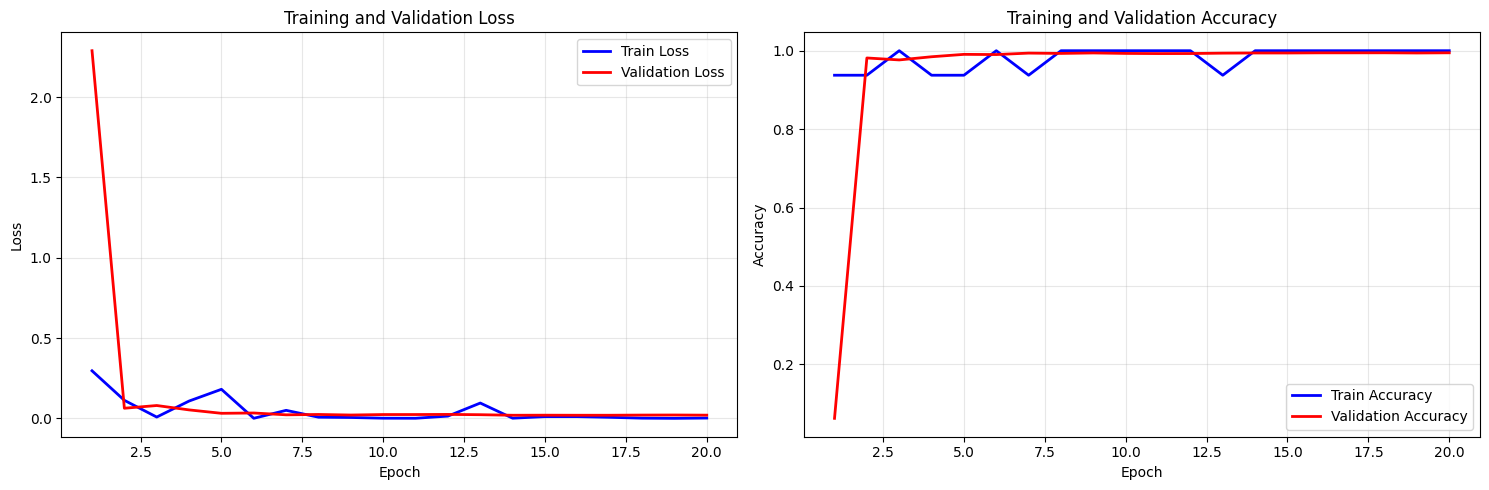

In [8]:
# Plot training curves
epochs = range(1, len(metrics_logger.train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(epochs, metrics_logger.train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, metrics_logger.val_losses[:len(metrics_logger.train_losses)], 'r-', label='Validation Loss',
linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs, metrics_logger.train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, metrics_logger.val_accs[:len(metrics_logger.train_accs)], 'r-', label='Validation Accuracy',
linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Training summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print("Model: AdvancedMNISTCNN")
print(f"Total Parameters: {total_params:,}")
print(f"Epochs: {config['max_epochs']}")
print(f"Batch Size: {config['batch_size']}")
print("Learning Rate Schedule: 0.003→0.001→0.0003→0.0001")
print(f"Dropout: {config['dropout']}")
print(f"Weight Decay: {config['weight_decay']}")
print("-"*60)
print(f"Final Train Accuracy: {metrics_logger.train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {metrics_logger.val_accs[-1]:.4f}")
print(f"Best Validation Accuracy: {max(metrics_logger.val_accs):.4f}")
print(f"Final Train Loss: {metrics_logger.train_losses[-1]:.6f}")
print(f"Final Validation Loss: {metrics_logger.val_losses[-1]:.6f}")
print("="*60)


TRAINING SUMMARY
Model: AdvancedMNISTCNN
Total Parameters: 19,306
Epochs: 20
Batch Size: 32
Learning Rate Schedule: 0.003→0.001→0.0003→0.0001
Dropout: 0.05
Weight Decay: 0
------------------------------------------------------------
Final Train Accuracy: 1.0000
Final Validation Accuracy: 0.9990
Best Validation Accuracy: 0.9990
Final Train Loss: 0.002002
Final Validation Loss: 0.005123


## Final Validation

In [15]:
model.eval()
model.to('mps')
data_module.setup()

def evaluate_dataset(dataloader, dataset_name):
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to('mps'), target.to('mps')
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    print(f"{dataset_name} accuracy: {accuracy:.4f}% ({correct}/{total})")
    return accuracy


train_acc = evaluate_dataset(data_module.train_dataloader(), "Train")
val_acc = evaluate_dataset(data_module.val_dataloader(), "Validation")
test_acc = evaluate_dataset(data_module.test_dataloader(), "Test")

print("\nSummary:")
print(f"Train: {train_acc:.4f}%")
print(f"Validation: {val_acc:.4f}%")
print(f"Test: {test_acc:.4f}%")

Train accuracy: 99.9000% (49950/50000)
Validation accuracy: 99.9300% (9993/10000)
Test accuracy: 99.3600% (9936/10000)

Summary:
Train: 99.9000%
Validation: 99.9300%
Test: 99.3600%


Total failed samples: 64

20 Random Failed Samples:
--------------------------------------------------
Sample 1: Index 2329 | Predicted: 2 | Actual: 0
Sample 2: Index 7216 | Predicted: 6 | Actual: 0
Sample 3: Index 8408 | Predicted: 5 | Actual: 8
Sample 4: Index 2597 | Predicted: 3 | Actual: 5
Sample 5: Index 2035 | Predicted: 3 | Actual: 5
Sample 6: Index 18 | Predicted: 9 | Actual: 3
Sample 7: Index 9015 | Predicted: 2 | Actual: 7
Sample 8: Index 1232 | Predicted: 4 | Actual: 9
Sample 9: Index 1039 | Predicted: 1 | Actual: 7
Sample 10: Index 2896 | Predicted: 0 | Actual: 8
Sample 11: Index 1242 | Predicted: 9 | Actual: 4
Sample 12: Index 6576 | Predicted: 1 | Actual: 7
Sample 13: Index 1737 | Predicted: 3 | Actual: 5
Sample 14: Index 2462 | Predicted: 0 | Actual: 2
Sample 15: Index 5955 | Predicted: 8 | Actual: 3
Sample 16: Index 445 | Predicted: 0 | Actual: 6
Sample 17: Index 1621 | Predicted: 6 | Actual: 0
Sample 18: Index 6625 | Predicted: 1 | Actual: 8
Sample 19: Index 938 | Pred

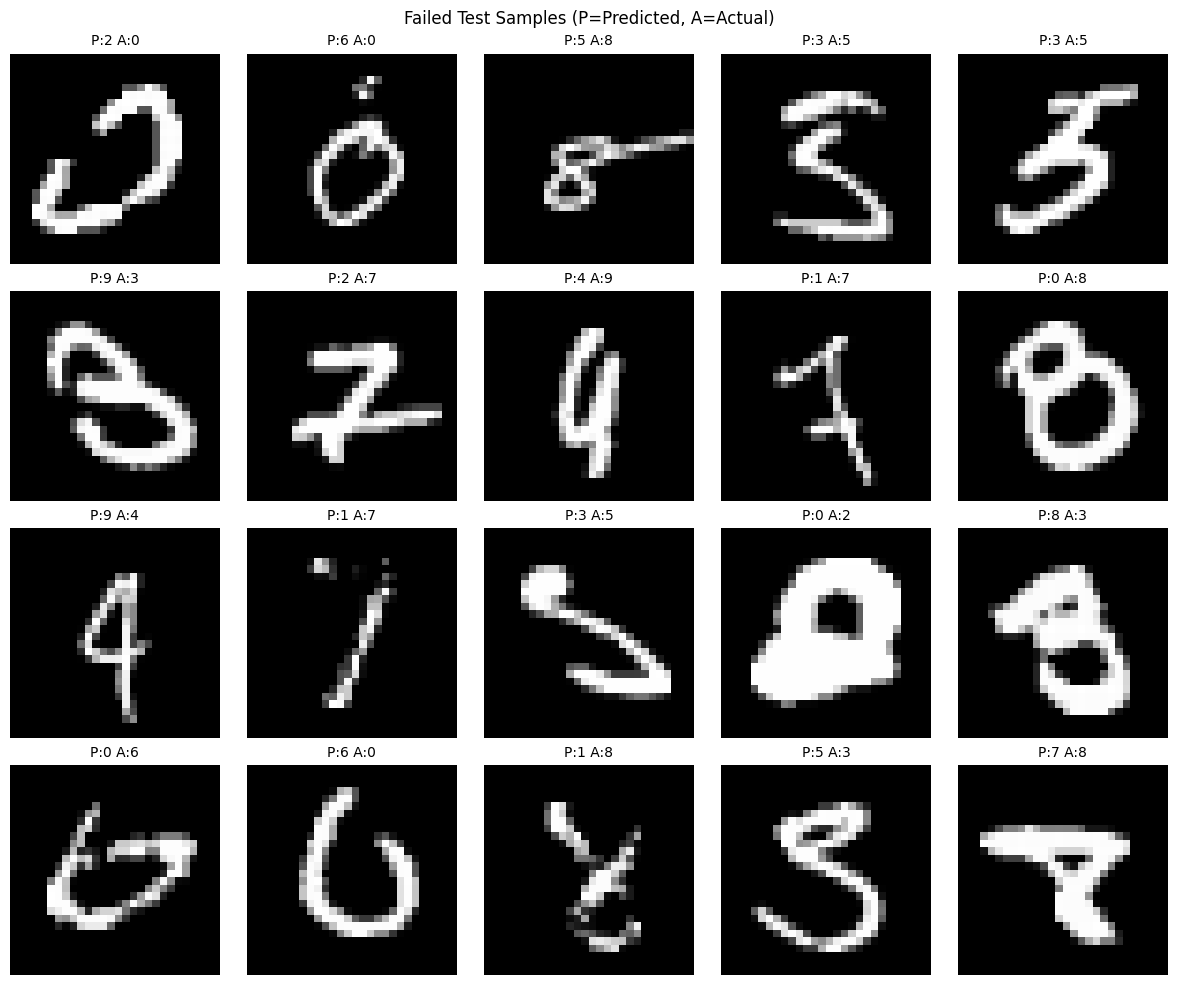

In [18]:
import random

model.eval()
model.to('mps')
test_loader = data_module.test_dataloader()

failed_samples = []
failed_preds = []
failed_targets = []
failed_indices = []

idx = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to('mps'), target.to('mps')
        output = model(data)
        pred = output.argmax(dim=1)

        # Find failed predictions in this batch
        failed_mask = pred != target

        if failed_mask.any():
            failed_batch_data = data[failed_mask]
            failed_batch_preds = pred[failed_mask]
            failed_batch_targets = target[failed_mask]

            for i in range(len(failed_batch_data)):
                failed_samples.append(failed_batch_data[i].cpu())
                failed_preds.append(failed_batch_preds[i].cpu().item())
                failed_targets.append(failed_batch_targets[i].cpu().item())
                failed_indices.append(idx + torch.where(failed_mask)[0][i].item())

        idx += len(data)

print(f"Total failed samples: {len(failed_samples)}")



sample_indices = random.sample(range(len(failed_samples)), min(20, len(failed_samples)))

print("\n20 Random Failed Samples:")
print("-" * 50)
for i, idx in enumerate(sample_indices):
    print(f"Sample {i+1}: Index {failed_indices[idx]} | Predicted: {failed_preds[idx]} | Actual: {failed_targets[idx]}")

# Optional: Visualize some failed samples
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i, idx in enumerate(sample_indices[:20]):
    row, col = i // 5, i % 5
    img = failed_samples[idx].squeeze()
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f"P:{failed_preds[idx]} A:{failed_targets[idx]}", fontsize=10)
    axes[row, col].axis('off')

plt.suptitle("Failed Test Samples (P=Predicted, A=Actual)")
plt.tight_layout()
plt.show()